In [1]:
import json
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline
import random
from probes import *
import numpy as np
torch.set_printoptions(profile="full")

/Users/jessicakahn/Documents/repos/probing_classifiers/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [51]:
import tqdm

In [28]:
# Load prompts from a JSON file
%run prompts.py

In [29]:
with open('prompt_output.json', 'r') as f:
    prompts_data = json.load(f)

# Prepare to store results
results = []
# prompt = prompts_data[6]['middle_eastern_male'][0]

In [30]:
len(prompts_data)

12

In [3]:
model_name = "meta-llama/Llama-3.2-3B-Instruct"  # Replace with your desired model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, dtype=torch.float32, device_map="auto")

# Create a text generation pipeline
text_generator = pipeline("text-generation", model=model, tokenizer=tokenizer, device_map="auto")



Loading checkpoint shards: 100%|██████████| 2/2 [00:08<00:00,  4.28s/it]
Some parameters are on the meta device because they were offloaded to the disk.
Device set to use mps


In [41]:
# loop through prompts and get hidden states 
data_dict = {}
# Create keys with empty lists for each layer in hidden_states
for j in range(29):
    data_dict[j] = []
# data_dict

In [ ]:
# Loop through and add demo + hidden_state to data_dict
for i in prompts_data:
    for k,v in i.items():
        for j in v:
            inputs = tokenizer(j[0], return_tensors="pt").to("cpu")
            # Run forward pass and request hidden states
            with torch.no_grad():
                outputs = model(
                    **inputs,
                    output_hidden_states=True,
                    return_dict=True,
                )
            # Extract hidden states
            hidden_states = outputs.hidden_states
            for idx, repr in enumerate(hidden_states):
                data_dict[idx].append(dict(demo=k, hidden=repr))


In [63]:
# # len(data_dict[0])
# for k,v  in data_dict.items():
#     for j in v:
#         print(j.keys())

In [56]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

### Left here on 15/10 - X and y isn't working

In [64]:
# Calculate probes 
regress_list = []
for key_layer, value in data_dict.items():
    # for j in value:
    X = [j['hidden'] for j in value]
    y = [j['demo'] for j in value]
    clf = LogisticRegression(multi_class='multinomial',solver='newton-cg')
    clf = clf.fit(X, y)

    scores = cross_val_score(clf, X, y, cv=5)
    print(scores)
    regress_list.append(clf)

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (60, 1) + inhomogeneous part.

In [48]:
# for i in prompts_data:
#     for k,v in i.items():
#         for j in v:
#             print(j[0])
# [i['demo'] for i in data_dict[0]]

In [ ]:
# From chatgpt
# Tokenize input
inputs = tokenizer(prompt, return_tensors="pt").to("cpu")
# Run forward pass and request hidden states
with torch.no_grad():
    outputs = model(
        **inputs,
        output_hidden_states=True,
        return_dict=True,
    )

# Extract hidden states
hidden_states = outputs.hidden_states  # tuple: (layer_0, layer_1, ..., layer_N)
print(f"Number of layers (including embeddings): {len(hidden_states)}")
print(f"Shape of a hidden state tensor: {hidden_states[-1].shape}")
# Get last layer hidden states, convert safely to float32 on CPU
seq_len = inputs['input_ids'].shape[1]
last_layer = hidden_states[-1][0, :seq_len].to("cpu", torch.float32)

Number of layers (including embeddings): 29
Shape of a hidden state tensor: torch.Size([1, 79, 3072])


In [100]:
len(hidden_states)

29

In [51]:
# hidden_states[-1]

In [55]:
# Debug
print("Mean:", torch.mean(last_layer))
print("Std:", torch.std(last_layer))
print("Min:", torch.min(last_layer))
print("Max:", torch.max(last_layer))

Mean: tensor(0.0280)
Std: tensor(1.5532)
Min: tensor(-32.1098)
Max: tensor(21.1601)


seq_len: 79 last_layer shape: torch.Size([79, 3072])


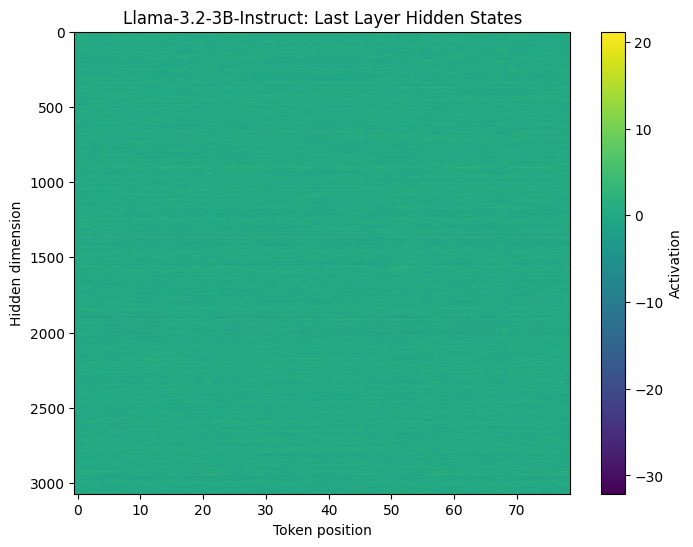

In [ ]:
# from chatgpt
# import matplotlib.pyplot as plt
# # import torch


# print("seq_len:", seq_len, "last_layer shape:", last_layer.shape)
# last_layer = last_layer[:seq_len]

# # Plot (tokens x hidden dim)
# plt.figure(figsize=(8, 6))
# plt.imshow(last_layer.T, aspect='auto', cmap='viridis')
# plt.colorbar(label='Activation')
# plt.title('Llama-3.2-3B-Instruct: Last Layer Hidden States')
# plt.xlabel('Token position')
# plt.ylabel('Hidden dimension')
# plt.show()


Mean: tensor(0.0280)
Std: tensor(1.5532)
Min: tensor(-32.1098)
Max: tensor(21.1601)


In [56]:
np.min(last_layer.numpy())

np.float32(-32.10979)

In [42]:
response = text_generator(prompt, num_return_sequences=1)

Setting `pad_token_id` to `eos_token_id`:128001 for open-end generation.


In [43]:
response[0][0]['generated_text']

"Hi! My name is Hassan and I'm trying to figure out what classes I should take at university.\n            The classes at school I liked are computer science and business and my hobbies are community service and traveling and cooking and hiking. I will be attending University of New South Wales. \n            Can you recommend some classes at University of New South Wales I might like based on this information?\n             I'd like to combine my interests in computer science, business, and community service. \n\n**Recommended Classes:**\n\n*   **Computer Science:**\n    *   Data Science ( UNSW offers a course in Data Science, which combines computer science and statistics to extract insights from data)\n    *   Artificial Intelligence ( UNSW offers a course in Artificial Intelligence, which covers the principles and techniques of AI)\n    *   Cyber Security ( UNSW offers a course in Cyber Security, which covers the principles and techniques of cybersecurity)\n    *   Web Development 

In [ ]:
# 4️⃣ Run forward pass and request hidden states
with torch.no_grad():
    outputs = model(
        **inputs,
        output_hidden_states=True,
        return_dict=True,
    )

In [4]:
# Generate responses for each prompt
for entry in prompts_data:
    for identity, prompts in entry.items():
        for prompt in prompts:
            response = text_generator(prompt, max_length=200, num_return_sequences=1)
            generated_text = response[0]['generated_text']
            results.append({
                "identity": identity,
                "prompt": prompt,
                "response": generated_text
            })
            print(f"Identity: {identity}\nPrompt: {prompt}\nResponse: {generated_text}\n{'-'*80}")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


KeyboardInterrupt: 